In this notebook we are going to try to assess the performances of USAD, but considering exclusively one decoder, instead of two. The performances will be assessed on the SWAT dataset

In [1]:
%cd /nfs/home/medoro/Unsupervised_Anomaly_Detection_thesis

/nfs/home/medoro/Unsupervised_Anomaly_Detection_thesis


In [4]:
from preprocessing import *
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as data_utils
from USAD.usad import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score
from postprocessing import *
import plotly.graph_objects as go
#from USAD.usad_conv import *

import warnings
warnings.filterwarnings('ignore')

# Dataset Preparation

In [5]:
dataframe = pd.read_csv(r"/nfs/home/medoro/Unsupervised_Anomaly_Detection_thesis/data/train.csv")
dataframe.shape

(1749494, 57)

In [6]:
df=dataframe[['building_id','primary_use', 'timestamp', 'meter_reading', 'sea_level_pressure', 'is_holiday','anomaly']]
df

,building_id,primary_use,timestamp,meter_reading,sea_level_pressure,is_holiday,anomaly
0,1,Education,2016-01-01 00:00:00,NaN,967.2,1,0
1,32,Office,2016-01-01 00:00:00,NaN,967.2,1,0
2,41,Office,2016-01-01 00:00:00,NaN,967.2,1,0
3,55,Office,2016-01-01 00:00:00,NaN,967.2,1,0
4,69,Parking,2016-01-01 00:00:00,NaN,967.2,1,0
...,...,...,...,...,...,...,...
1749489,1316,Entertainment/public assembly,2016-12-31 23:00:00,38.844,967.2,0,0
1749490,1318,Entertainment/public assembly,2016-12-31 23:00:00,202.893,967.2,0,0
1749491,1319,Entertainment/public assembly,2016-12-31 23:00:00,NaN,967.2,0,0
1749492,1323,Office,2016-12-31 23:00:00,172.000,967.2,0,0


In [7]:
imputed_df = impute_nulls(df)
imputed_df

,building_id,primary_use,timestamp,meter_reading,sea_level_pressure,is_holiday,anomaly,is_na
0,1,Education,2016-01-01 00:00:00,31.477940,967.2,1,0,True
200,1,Education,2016-01-01 01:00:00,29.582970,1019.4,1,0,True
398,1,Education,2016-01-01 02:00:00,28.635485,1018.8,1,0,True
597,1,Education,2016-01-01 03:00:00,28.161742,1018.1,1,0,True
796,1,Education,2016-01-01 04:00:00,27.924871,1019.0,1,0,True
...,...,...,...,...,...,...,...,...
1748693,1353,Religious worship,2016-12-31 19:00:00,2.425000,967.2,0,0,False
1748893,1353,Religious worship,2016-12-31 20:00:00,2.450000,967.2,0,0,False
1749093,1353,Religious worship,2016-12-31 21:00:00,2.425000,967.2,0,0,False
1749293,1353,Religious worship,2016-12-31 22:00:00,2.450000,967.2,0,0,False


Now that we have imputed the missing values for the column containing the energy consumption measurements, we can procees by adding a couple of features more and further imputing the missing dates for each timeseries in the dataset.

In [8]:
df = add_trigonometric_features(imputed_df)
df

,building_id,primary_use,timestamp,meter_reading,sea_level_pressure,is_holiday,anomaly,is_na,weekday,weekday_y,weekday_x
0,1,Education,2016-01-01 00:00:00,31.477940,967.2,1,0,True,4,-0.433884,-0.900969
200,1,Education,2016-01-01 01:00:00,29.582970,1019.4,1,0,True,4,-0.433884,-0.900969
398,1,Education,2016-01-01 02:00:00,28.635485,1018.8,1,0,True,4,-0.433884,-0.900969
597,1,Education,2016-01-01 03:00:00,28.161742,1018.1,1,0,True,4,-0.433884,-0.900969
796,1,Education,2016-01-01 04:00:00,27.924871,1019.0,1,0,True,4,-0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...
1748693,1353,Religious worship,2016-12-31 19:00:00,2.425000,967.2,0,0,False,5,-0.974928,-0.222521
1748893,1353,Religious worship,2016-12-31 20:00:00,2.450000,967.2,0,0,False,5,-0.974928,-0.222521
1749093,1353,Religious worship,2016-12-31 21:00:00,2.425000,967.2,0,0,False,5,-0.974928,-0.222521
1749293,1353,Religious worship,2016-12-31 22:00:00,2.450000,967.2,0,0,False,5,-0.974928,-0.222521


In [9]:
dfs_dict = impute_missing_dates(df)

In [11]:
df1 = pd.concat(dfs_dict.values())
df1

,building_id,primary_use,meter_reading,sea_level_pressure,is_holiday,anomaly,is_na,weekday,weekday_y,weekday_x
2016-01-01 00:00:00,1,Education,31.477940,967.2,1,0,True,4,-0.433884,-0.900969
2016-01-01 01:00:00,1,Education,29.582970,1019.4,1,0,True,4,-0.433884,-0.900969
2016-01-01 02:00:00,1,Education,28.635485,1018.8,1,0,True,4,-0.433884,-0.900969
2016-01-01 03:00:00,1,Education,28.161742,1018.1,1,0,True,4,-0.433884,-0.900969
2016-01-01 04:00:00,1,Education,27.924871,1019.0,1,0,True,4,-0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,1353,Religious worship,2.425000,967.2,0,0,False,5,-0.974928,-0.222521
2016-12-31 20:00:00,1353,Religious worship,2.450000,967.2,0,0,False,5,-0.974928,-0.222521
2016-12-31 21:00:00,1353,Religious worship,2.425000,967.2,0,0,False,5,-0.974928,-0.222521
2016-12-31 22:00:00,1353,Religious worship,2.450000,967.2,0,0,False,5,-0.974928,-0.222521


Let's now obtain the train and validation set. We are going to split the dataset into 2 sets, according to the building id.

In [12]:
dfs_train, dfs_val, dfs_test = train_val_test_split(df1)
train = pd.concat(dfs_train.values())

In [13]:
val = pd.concat(dfs_val.values())

In [14]:
test = pd.concat(dfs_test.values())

In [15]:
train

,building_id,primary_use,meter_reading,sea_level_pressure,is_holiday,anomaly,is_na,weekday,weekday_y,weekday_x
2016-01-01 00:00:00,1,Education,31.477940,967.2,1,0,True,4,-0.433884,-0.900969
2016-01-01 01:00:00,1,Education,29.582970,1019.4,1,0,True,4,-0.433884,-0.900969
2016-01-01 02:00:00,1,Education,28.635485,1018.8,1,0,True,4,-0.433884,-0.900969
2016-01-01 03:00:00,1,Education,28.161742,1018.1,1,0,True,4,-0.433884,-0.900969
2016-01-01 04:00:00,1,Education,27.924871,1019.0,1,0,True,4,-0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,1238,Office,54.900000,967.2,0,0,False,5,-0.974928,-0.222521
2016-12-31 20:00:00,1238,Office,56.000000,967.2,0,0,False,5,-0.974928,-0.222521
2016-12-31 21:00:00,1238,Office,66.400000,967.2,0,0,False,5,-0.974928,-0.222521
2016-12-31 22:00:00,1238,Office,67.100000,967.2,0,0,False,5,-0.974928,-0.222521


In [16]:
val

,building_id,primary_use,meter_reading,sea_level_pressure,is_holiday,anomaly,is_na,weekday,weekday_y,weekday_x
2016-01-01 00:00:00,1241,Healthcare,234.180,1018.9,1,0,False,4,-0.433884,-0.900969
2016-01-01 01:00:00,1241,Healthcare,294.156,1018.4,1,0,False,4,-0.433884,-0.900969
2016-01-01 02:00:00,1241,Healthcare,354.152,1018.2,1,0,False,4,-0.433884,-0.900969
2016-01-01 03:00:00,1241,Healthcare,294.121,1018.3,1,0,False,4,-0.433884,-0.900969
2016-01-01 04:00:00,1241,Healthcare,294.102,1018.2,1,0,False,4,-0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,1353,Religious worship,2.425,967.2,0,0,False,5,-0.974928,-0.222521
2016-12-31 20:00:00,1353,Religious worship,2.450,967.2,0,0,False,5,-0.974928,-0.222521
2016-12-31 21:00:00,1353,Religious worship,2.425,967.2,0,0,False,5,-0.974928,-0.222521
2016-12-31 22:00:00,1353,Religious worship,2.450,967.2,0,0,False,5,-0.974928,-0.222521


In [17]:
test

,building_id,primary_use,meter_reading,sea_level_pressure,is_holiday,anomaly,is_na,weekday,weekday_y,weekday_x
2016-01-01 00:00:00,69,Parking,19.232375,967.2,1,0,True,4,-0.433884,-0.900969
2016-01-01 01:00:00,69,Parking,13.457187,1019.4,1,0,True,4,-0.433884,-0.900969
2016-01-01 02:00:00,69,Parking,10.569594,1018.8,1,0,True,4,-0.433884,-0.900969
2016-01-01 03:00:00,69,Parking,9.125797,1018.1,1,0,True,4,-0.433884,-0.900969
2016-01-01 04:00:00,69,Parking,8.403898,1019.0,1,0,True,4,-0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,1319,Entertainment/public assembly,132.040616,967.2,0,0,True,5,-0.974928,-0.222521
2016-12-31 20:00:00,1319,Entertainment/public assembly,132.040616,967.2,0,0,True,5,-0.974928,-0.222521
2016-12-31 21:00:00,1319,Entertainment/public assembly,132.040616,967.2,0,0,True,5,-0.974928,-0.222521
2016-12-31 22:00:00,1319,Entertainment/public assembly,132.040616,967.2,0,0,True,5,-0.974928,-0.222521


# Training

In [18]:
train_window = 72

In [19]:
X_train, y_train = create_train_eval_sequences(train, train_window)

In [20]:
X_train.shape, y_train.shape

((1123848, 72, 1), (1123848, 72))

In [21]:
BATCH_SIZE =  128
N_EPOCHS = 40
hidden_size = 1/8

In [23]:
w_size = X_train.shape[1] * X_train.shape[2]
z_size = int(w_size * hidden_size) #X_train.shape[1] * hidden_size 
w_size, z_size

(72, 9)

In [24]:
import torch.utils.data as data_utils

In [25]:
train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(torch.from_numpy(X_train).float().view(([X_train.shape[0], w_size]))), batch_size = BATCH_SIZE, shuffle = False, num_workers = 0)

In [26]:
X_val, y_val = create_train_eval_sequences(val, train_window)

In [27]:
X_val.shape, y_val.shape

((287496, 72, 1), (287496, 72))

In [28]:
val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(torch.from_numpy(X_val).float().view(([X_val.shape[0],w_size]))) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [29]:
device = get_default_device()
device

device(type='cpu')

In [ ]:
! export CUDA_VISIBLE_DEVICES=2

In [30]:
model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [ ]:
N_EPOCHS = 50

In [ ]:
history = training(N_EPOCHS,model,train_loader,val_loader) #2.15 min a epoch ---> 7/11% gpu (uni/multi) #Conv_autoencoder: 2.45 min --> 22% gpu

In [ ]:
plot_history(history)

In [ ]:
print(model)

In [ ]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "/home/medoro/Unsupervised_Anomaly_Detection_thesis/checkpoints/model_40epochs_univariate.pth")

# Testing the model

In [31]:
checkpoint = torch.load("checkpoints/model_40epochs_univariate.pth", map_location = torch.device('cpu'))

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

## Testing with non-overlapping windows

In [ ]:
X_test, y_test = create_test_sequences(test, train_window) #creo sequenze non overlappate

In [ ]:
X_test.shape, y_test.shape #non-overlapping

In [ ]:
test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(X_test).float().view(([X_test.shape[0],w_size, 1]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
def reconstruction(model, test_loader):
  # QUI: il test loader che viene passato è ottenuto con non-overlapping sliding window
  tensors_w1 = []
  tensors_w2 = []
  with torch.no_grad():
      for [batch] in test_loader: #N.B.: batch, w1, w2 sono tensori torch.tensor
          batch=to_device(batch,device)
          w1=model.decoder1(model.encoder(batch))
          w2=model.decoder2(model.encoder(w1))
          tensors_w1.append(w1)
          tensors_w2.append(w2)
  # Restituisci solo le ricostruzioni da parte dei due autoencoder
  # Per determinare le anomalie: come facevamo con le baseline, da capire solo come mettere insieme i risultati del primo e del secondo decoder
  # Forse anche qui possiamo calcolare le loss, e almeno per il momento farne una media pesata... no?
  return tensors_w1, tensors_w2

In [ ]:
w1_non_overl, w2_non_overl = reconstruction(model, test_loader)

In [ ]:
w1_non_overl.size()

In [ ]:
w1_non_overl

In [ ]:
# CELLA DA FAR GIRARE SE SI STA USANDO usad_conv
w1_new = [torch.reshape(w1_el, (w1_el.size()[0], w1_el.size()[1])) for w1_el in w1_non_overl]
w2_new = [torch.reshape(w2_el, (w2_el.size()[0], w2_el.size()[1])) for w2_el in w2_non_overl]

In [ ]:
len(w1_non_overl), w1_non_overl[0].size(), w1_non_overl[-1].size()

In [ ]:
36*128 + 28

Now that we have our results, given that the input consisted in non overlapping windows, we can just concatenate the values, into creating a single list of reconstructed values, and then perform anomaly detection as usual, by considering the difference with respect to the ground truth.

In [ ]:
# Operations to do for w1 (output of the first autoencoder)
reshaped_w1 = [torch.flatten(w1_el) for w1_el in w1_non_overl]

In [ ]:
len(reshaped_w1), reshaped_w1[0].size(), reshaped_w1[-1].size()

In [ ]:
# Per i primi 36 tensori, che hanno stessa size, possiamo usare stack per ottenere un unico tensore di 36 * 9216 = 331776 elementi
stacked = torch.stack(reshaped_w1[:-1]).flatten()
stacked.shape

In [ ]:
stacked_array = stacked.cpu().numpy()
stacked_array

In [ ]:
last_array = reshaped_w1[-1].cpu().numpy()
last_array

In [ ]:
total = np.concatenate([stacked_array, last_array])

In [ ]:
len(total)

In [ ]:
# SAME for w2
reshaped_w2 = [torch.flatten(w2_el) for w2_el in w2_non_overl]
stacked2 = torch.stack(reshaped_w2[:-1]).flatten()
stacked_array2 = stacked2.cpu().numpy()
last_array2 = reshaped_w2[-1].cpu().numpy()
total2 = np.concatenate([stacked_array2, last_array2])
len(total2)

In [ ]:
total2

Now we need to create the dataset to perform anomaly detection

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))

In [ ]:
dfs_dict_1 = {}
for building_id, gdf in test.groupby("building_id"):
  gdf[['meter_reading']]=scaler.fit_transform(gdf[['meter_reading']])
  dfs_dict_1[building_id] = gdf
predicted_df_test = pd.concat(dfs_dict_1.values())

In [ ]:
predicted_df_test['reconstruction1'] = total

In [ ]:
predicted_df_test['reconstruction2'] = total2

In [ ]:
predicted_df_test

In [ ]:
predicted_df_test.reconstruction2.min(), predicted_df_test.reconstruction2.max()

In [ ]:
predicted_df_test.reconstruction1.min(), predicted_df_test.reconstruction1.max()

In [ ]:
predicted_df_test['relative_loss'] = np.abs((predicted_df_test['reconstruction1']-predicted_df_test['meter_reading'])/predicted_df_test['reconstruction1'])

In [ ]:
predicted_df_test['relative_loss2'] = np.abs((predicted_df_test['reconstruction2']-predicted_df_test['meter_reading'])/predicted_df_test['reconstruction2'])

In [ ]:
#calculate threshold on relative loss quartiles but only on val, and in this case per building
thresholds=np.array([])
for building_id, gdf in predicted_df_test.groupby("building_id"):
  val_mre_loss_building= gdf['relative_loss'].values
  building_threshold = (np.percentile(val_mre_loss_building, 75)) + 1.5 *((np.percentile(val_mre_loss_building, 75))-(np.percentile(val_mre_loss_building, 25)))
  gdf['threshold']=building_threshold
  thresholds= np.append(thresholds, gdf['threshold'].values)
print(thresholds.shape)
predicted_df_test['threshold']= thresholds

In [ ]:
#calculate threshold on relative loss quartiles but only on val, and in this case per building
thresholds=np.array([])
for building_id, gdf in predicted_df_test.groupby("building_id"):
  val_mre_loss_building= gdf['relative_loss2'].values
  building_threshold = (np.percentile(val_mre_loss_building, 75)) + 1.5 *((np.percentile(val_mre_loss_building, 75))-(np.percentile(val_mre_loss_building, 25)))
  gdf['threshold2']=building_threshold
  thresholds= np.append(thresholds, gdf['threshold2'].values)
print(thresholds.shape)
predicted_df_test['threshold2']= thresholds

In [ ]:
predicted_df_test['predicted_anomaly'] = predicted_df_test['relative_loss'] > predicted_df_test['threshold']
predicted_df_test['predicted_anomaly']=predicted_df_test['predicted_anomaly'].replace(False,0)
predicted_df_test['predicted_anomaly']=predicted_df_test['predicted_anomaly'].replace(True,1)

In [ ]:
predicted_df_test['predicted_anomaly2'] = predicted_df_test['relative_loss2'] > predicted_df_test['threshold2']
predicted_df_test['predicted_anomaly2']=predicted_df_test['predicted_anomaly2'].replace(False,0)
predicted_df_test['predicted_anomaly2']=predicted_df_test['predicted_anomaly2'].replace(True,1)

In [ ]:
predicted_df_test.index.names=['timestamp']
predicted_df_test= predicted_df_test.reset_index()

In [ ]:
predicted_df_test.predicted_anomaly.unique()

In [ ]:
predicted_df_test.predicted_anomaly2.unique()

In [ ]:
predicted_anomalies = predicted_df_test.loc[predicted_df_test['predicted_anomaly'] == 1]
predicted_anomalies2 = predicted_df_test.loc[predicted_df_test['predicted_anomaly2'] == 1]
true_anomalies = predicted_df_test.loc[predicted_df_test['anomaly'] == 1]

In [ ]:
predicted_df_test = pd.merge(predicted_df_test, df[['timestamp','building_id']], on=['timestamp','building_id'])

In [ ]:
print(classification_report(predicted_df_test['anomaly'], predicted_df_test['predicted_anomaly']))

In [ ]:
print(classification_report(predicted_df_test['anomaly'], predicted_df_test['predicted_anomaly2']))

In [ ]:
roc_auc_score(predicted_df_test['anomaly'], predicted_df_test['predicted_anomaly'])

In [ ]:
roc_auc_score(predicted_df_test['anomaly'], predicted_df_test['predicted_anomaly2'])

In [ ]:
len(true_anomalies), len(predicted_anomalies), len(predicted_anomalies2)

In [ ]:
len(predicted_anomalies) / len(predicted_df_test), len(predicted_anomalies2) / len(predicted_df_test)

In [ ]:
predicted_df_test.building_id.unique()

In [ ]:
visualizations = predicted_df_test[predicted_df_test.building_id == 1264]
visualizations

In [ ]:
plt.plot(visualizations.meter_reading, label = "meter reading") 
plt.plot(visualizations.reconstruction, label = "w1_reconstruction")
plt.plot(visualizations.reconstruction2, label = "w2_reconstruction")
plt.legend()
plt.show()

In [ ]:
predicted_anomalies = visualizations.loc[visualizations['predicted_anomaly'] == 1]
predicted_anomalies2 = visualizations.loc[visualizations['predicted_anomaly2'] == 1]
true_anomalies = visualizations.loc[visualizations['anomaly'] == 1]

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=visualizations.index, y=visualizations['meter_reading'], name='meter readings'))
fig.add_trace(go.Scatter(x=visualizations.index, y=visualizations['reconstruction'], name='w1 reconstructed'))
fig.add_trace(go.Scatter(x=visualizations.index, y=visualizations['reconstruction2'], name='w2 reconstructed'))

fig.add_trace(go.Scatter(x=true_anomalies.index, y=true_anomalies['meter_reading'], mode='markers', marker=dict(color='forestgreen'), name='True_Anomaly'))
fig.add_trace(go.Scatter(x=predicted_anomalies.index, y=predicted_anomalies['meter_reading'], mode='markers', marker=dict(color='yellow'), name='W1_Anomaly'))
fig.add_trace(go.Scatter(x=predicted_anomalies2.index, y=predicted_anomalies2['meter_reading'], mode='markers', marker=dict(color='orange'), name='W2_Anomaly'))
fig.update_layout(showlegend=True, title='meter readings predicted and anomalies - val')
fig.show()

# Testing the model (overlapping windows; anomaly score-based)

In [34]:
X_test, y_test = create_train_eval_sequences(test, train_window)

In [35]:
X_test.shape, y_test.shape

((331056, 72, 1), (331056, 72))

In [36]:
test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(torch.from_numpy(X_test).float().view(([X_test.shape[0],w_size]))) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [140]:
results=testing(model,test_loader) #Prova con il test set

In [141]:
results

[tensor([0.0458, 0.0463, 0.0467, 0.0469, 0.0470, 0.0471, 0.0471, 0.0471, 0.0472,
         0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472,
         0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472,
         0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472,
         0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472,
         0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472,
         0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472,
         0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472,
         0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472,
         0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472,
         0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472,
         0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472, 0.0472,
         0.0472, 0.0472, 0.0

In [142]:
labels = test.anomaly.values

In [143]:
labels

array([0, 0, 0, ..., 0, 0, 0])

In [144]:
# Qui va ad ottenere le label per ogni finestra
# Input modello è una lista di array, ognuno corrispondente a una sliding window con stride = 1 sui dati originali
# Quindi dobbiamo applicare la sliding window anche sulle label
windows_labels=[]
for b_id, gdf in test.groupby('building_id'):
    labels = gdf.anomaly.values
    for i in range(len(labels)-train_window):
        windows_labels.append(list(np.int_(labels[i:i+train_window])))
windows_labels

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0

In [145]:
len(windows_labels)

331056

In [146]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ]
# Qui vado a dare le label 1 per ogni finestra: se tutta la finestra contiene label = 0, allora y_test(t) = 0, altrimenti = 1

In [147]:
np.sum(y_test)

53736.0

In [148]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

In [149]:
y_pred

array([0.04579739, 0.04629022, 0.04667915, ..., 0.00724935, 0.00718706,
       0.00712019], dtype=float32)

In [150]:
len(y_test), len(y_pred)

(331056, 331056)

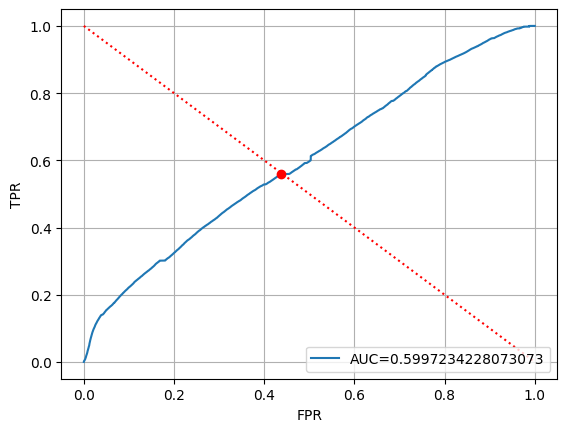

In [151]:
threshold=ROC(y_test,y_pred)

In [152]:
y_pred_ = np.zeros(y_pred.shape[0])

In [153]:
y_pred_[y_pred >= threshold] = 1

In [154]:
roc_auc_score(y_test, y_pred_)

0.5612009515307846

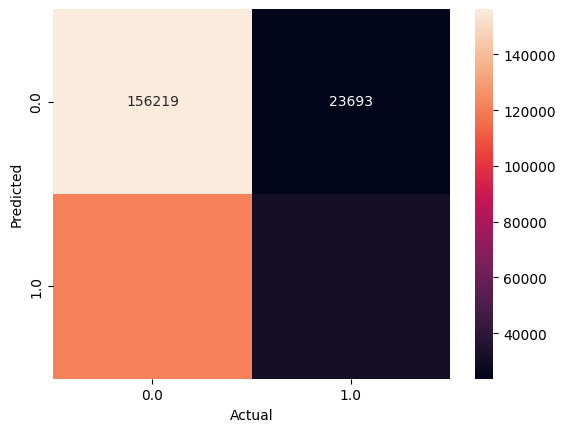

In [155]:
confusion_matrix(np.array(y_test), y_pred_)

In [156]:
print(classification_report(y_test, y_pred_))

              precision    recall  f1-score   support

         0.0       0.87      0.56      0.68    277320
         1.0       0.20      0.56      0.29     53736

    accuracy                           0.56    331056
   macro avg       0.53      0.56      0.49    331056
weighted avg       0.76      0.56      0.62    331056



In [182]:
threshold = np.percentile(y_pred, 70)
print(threshold)
y_pred_ = np.zeros(y_pred.shape[0])
y_pred_[y_pred >= threshold] = 1

0.03862686268985271


In [183]:
y_pred_.sum(), y_pred_.sum()/len(y_pred_), len(y_pred_)

(99317.0, 0.3000006041273984, 331056)

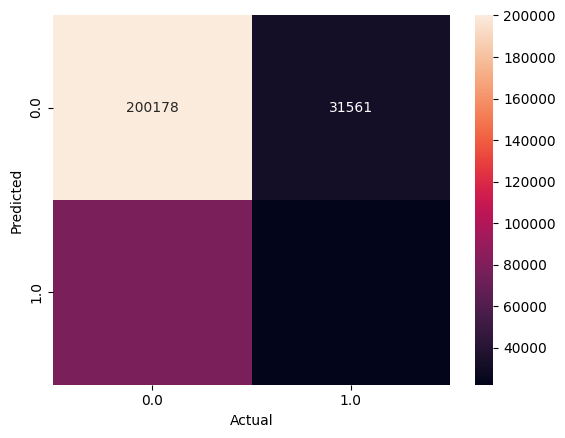

In [184]:
confusion_matrix(np.array(y_test), y_pred_)

In [185]:
print(classification_report(y_test, y_pred_))

              precision    recall  f1-score   support

         0.0       0.86      0.72      0.79    277320
         1.0       0.22      0.41      0.29     53736

    accuracy                           0.67    331056
   macro avg       0.54      0.57      0.54    331056
weighted avg       0.76      0.67      0.71    331056



In [186]:
roc_auc_score(y_test, y_pred_)

0.5672480004975847

Now these results can be further refined by handling the potential anomalies corresponding to the missing values, which should always be associated to non-anomalous values. Let's start with creating the dataframe.

In [187]:
scaler = MinMaxScaler(feature_range = (0, 1))
dfs_dict_1 = {}
for building_id, gdf in test.groupby("building_id"):
  gdf[['meter_reading', 'sea_level_pressure']]=scaler.fit_transform(gdf[['meter_reading', 'sea_level_pressure']])
  dfs_dict_1[building_id] = gdf[train_window:]
predicted_df = pd.concat(dfs_dict_1.values())

In [188]:
predicted_df

,building_id,primary_use,meter_reading,sea_level_pressure,is_holiday,anomaly,is_na,weekday,weekday_y,weekday_x
2016-01-04 00:00:00,69,Parking,0.139088,0.757143,0,0,True,0,0.000000,1.000000
2016-01-04 01:00:00,69,Parking,0.139088,0.760317,0,0,True,0,0.000000,1.000000
2016-01-04 02:00:00,69,Parking,0.139088,0.746032,0,0,True,0,0.000000,1.000000
2016-01-04 03:00:00,69,Parking,0.139088,0.742857,0,0,True,0,0.000000,1.000000
2016-01-04 04:00:00,69,Parking,0.139088,0.738095,0,0,True,0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,1319,Entertainment/public assembly,0.336511,0.000000,0,0,True,5,-0.974928,-0.222521
2016-12-31 20:00:00,1319,Entertainment/public assembly,0.336511,0.000000,0,0,True,5,-0.974928,-0.222521
2016-12-31 21:00:00,1319,Entertainment/public assembly,0.336511,0.000000,0,0,True,5,-0.974928,-0.222521
2016-12-31 22:00:00,1319,Entertainment/public assembly,0.336511,0.000000,0,0,True,5,-0.974928,-0.222521


In [189]:
predicted_df['predicted_anomaly'] = y_pred

In [190]:
def postprocessing_on_missing_values(dataframe_original, dataframe_post_reconstruction):
  corrected = []
  for i, row in dataframe_post_reconstruction.iterrows():
    if row.is_na == True:
      corrected.append(0)
    else:
      corrected.append(row.predicted_anomaly)
  dataframe_post_reconstruction.predicted_anomaly = corrected
  #dataframe_post_reconstruction = pd.merge(dataframe_post_reconstruction, dataframe_original[['timestamp', 'building_id']], on = ['timestamp', 'building_id'])
  return dataframe_post_reconstruction

In [191]:
predicted_df_2 = postprocessing_on_missing_values(test, predicted_df)

In [192]:
predicted_df_2

,building_id,primary_use,meter_reading,sea_level_pressure,is_holiday,anomaly,is_na,weekday,weekday_y,weekday_x,predicted_anomaly
2016-01-04 00:00:00,69,Parking,0.139088,0.757143,0,0,True,0,0.000000,1.000000,0.0
2016-01-04 01:00:00,69,Parking,0.139088,0.760317,0,0,True,0,0.000000,1.000000,0.0
2016-01-04 02:00:00,69,Parking,0.139088,0.746032,0,0,True,0,0.000000,1.000000,0.0
2016-01-04 03:00:00,69,Parking,0.139088,0.742857,0,0,True,0,0.000000,1.000000,0.0
2016-01-04 04:00:00,69,Parking,0.139088,0.738095,0,0,True,0,0.000000,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,1319,Entertainment/public assembly,0.336511,0.000000,0,0,True,5,-0.974928,-0.222521,0.0
2016-12-31 20:00:00,1319,Entertainment/public assembly,0.336511,0.000000,0,0,True,5,-0.974928,-0.222521,0.0
2016-12-31 21:00:00,1319,Entertainment/public assembly,0.336511,0.000000,0,0,True,5,-0.974928,-0.222521,0.0
2016-12-31 22:00:00,1319,Entertainment/public assembly,0.336511,0.000000,0,0,True,5,-0.974928,-0.222521,0.0


In [193]:
predicted_df_2.predicted_anomaly.sum()

9257.049147632177

In [194]:
threshold = np.percentile(predicted_df_2.predicted_anomaly.values, 70)
print(threshold)
y_pred_ = np.zeros(y_pred.shape[0])
y_pred_[y_pred >= threshold] = 1

0.037472276017069796


In [195]:
print(classification_report(y_test, y_pred_))

              precision    recall  f1-score   support

         0.0       0.86      0.71      0.78    277320
         1.0       0.22      0.43      0.29     53736

    accuracy                           0.66    331056
   macro avg       0.54      0.57      0.53    331056
weighted avg       0.76      0.66      0.70    331056



In [134]:
roc_auc_score(y_test, y_pred_)

0.5904905391275532

In [104]:
alpha_val = np.arange(0, 1.05, 0.05)
beta_val = alpha_val[::-1]

In [105]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [106]:
# Grid-search over alpha and beta
best_combination = []
best_metrics = []
all_combin = []
for i in range(len(alpha_val)):
  print(round(alpha_val[i],2), round(beta_val[i],2))
  results = testing(model, test_loader, alpha = round(alpha_val[i], 2), beta = round(beta_val[i],2))
  y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(), results[-1].flatten().detach().cpu().numpy()])
  threshold = np.percentile(y_pred, 70)
  y_pred_ = np.zeros(y_pred.shape[0])
  y_pred_[y_pred >= threshold] = 1
  roc = roc_auc_score(y_test, y_pred_)
  prec = precision_score(y_test, y_pred_)
  rec = recall_score(y_test, y_pred_)
  f1 = f1_score(y_test, y_pred_)
  all_combin.append([roc, prec, rec, f1])
  if i == 0:
    best_combination = [round(alpha_val[i],2), round(beta_val[i],2)]
    best_metrics = [roc, prec, rec, f1]
  else:
    if roc > best_metrics[0] and prec > best_metrics[1] and rec > best_metrics[2] and f1 > best_metrics[3]:
      best_combination = [round(alpha_val[i],2), round(beta_val[i],2)]
      best_metrics = [roc, prec, rec, f1]

0.0 1.0
0.05 0.95
0.1 0.9
0.15 0.85
0.2 0.8
0.25 0.75
0.3 0.7
0.35 0.65
0.4 0.6
0.45 0.55
0.5 0.5
0.55 0.45
0.6 0.4
0.65 0.35
0.7 0.3
0.75 0.25
0.8 0.2
0.85 0.15
0.9 0.1
0.95 0.05
1.0 0.0


In [107]:
best_combination, best_metrics

([0.9, 0.1],
 [0.6006378081422087,
  0.25354168974093055,
  0.46860577638826856,
  0.32904941425519263])

In [108]:
all_combin

[[0.5478872437695143,
  0.20572510244973166,
  0.38022926901890725,
  0.2669924797292441],
 [0.5486536764799198,
  0.20641984755882678,
  0.3815133244007742,
  0.26789412817782077],
 [0.5496978022013418,
  0.20736631191034768,
  0.38326261723983923,
  0.26912246084689617],
 [0.551419498869644,
  0.20892697121338744,
  0.38614708947446774,
  0.2711479030139886],
 [0.5534744271511662,
  0.21078969360733812,
  0.3895898466577341,
  0.2735653662456796],
 [0.5552294469807905,
  0.21238055921946897,
  0.3925301473872264,
  0.2756300105192319],
 [0.557106651735262,
  0.21408218129826717,
  0.39567515259788594,
  0.2778383958498037],
 [0.5588838870057676,
  0.21569318444979207,
  0.3986526723239541,
  0.2799291748609959],
 [0.5609388152872898,
  0.21755590684374276,
  0.4020954295072205,
  0.28234663809268684],
 [0.5634824832682009,
  0.21986165510436279,
  0.40635700461515556,
  0.2853390655524557],
 [0.5672480004975847,
  0.22327496803165622,
  0.4126656245347625,
  0.28976890358241914],
 [0

### My metrics -> not like USAD

Let's create the dataset to perform predictions.

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))

In [ ]:
dfs_dict_1 = {}
for building_id, gdf in test.groupby("building_id"):
  gdf[['meter_reading', 'sea_level_pressure']]=scaler.fit_transform(gdf[['meter_reading', 'sea_level_pressure']])
  dfs_dict_1[building_id] = gdf[train_window:]
predicted_df = pd.concat(dfs_dict_1.values())

In [ ]:
lista = []
for el in results:
  for el2 in el:
    lista.append(el2.cpu().item())
lista

In [ ]:
plt.hist(lista, bins=50)
plt.xlabel("Anomaly score")
plt.ylabel("No of samples")
plt.show()

In [ ]:
predicted_df['anomaly_score'] = lista

In [ ]:
predicted_df

In [ ]:
predicted_df.anomaly_score.min(), predicted_df.anomaly_score.max() 

In [ ]:
perc = 90
threshold = (np.percentile(predicted_df.anomaly_score.values, perc))

In [ ]:
threshold

In [ ]:
predicted_df['threshold'] = threshold

In [ ]:
predicted_df['predicted_anomaly'] = predicted_df.anomaly_score > predicted_df['threshold']
predicted_df['predicted_anomaly']=predicted_df['predicted_anomaly'].replace(False,0)
predicted_df['predicted_anomaly']=predicted_df['predicted_anomaly'].replace(True,1)

In [ ]:
predicted_df.predicted_anomaly.unique()

In [ ]:
len(predicted_df[predicted_df.predicted_anomaly == 1])/len(predicted_df)

In [ ]:
predicted_df.index.names=['timestamp']
predicted_df= predicted_df.reset_index()

In [ ]:
predicted_df = pd.merge(predicted_df, df[['timestamp','building_id']], on=['timestamp','building_id'])

In [ ]:
print(classification_report(predicted_df.anomaly, predicted_df.predicted_anomaly))

In [ ]:
roc_auc_score(predicted_df['anomaly'], predicted_df['predicted_anomaly'])

# Testing the model (overlapping windows; reconstruction-based)

In [ ]:
results, w1, w2 = testing_prova(model, test_loader)

In [ ]:
w1

In [ ]:
w2

In [ ]:
# CELLA DA FAR GIRARE SE SI STA USANDO usad_conv
w1_new = [torch.reshape(w1_el, (w1_el.size()[0], w1_el.size()[1])) for w1_el in w1]
w2_new = [torch.reshape(w2_el, (w2_el.size()[0], w2_el.size()[1])) for w2_el in w2]

In [ ]:
w1

In [ ]:
padded_w1 = padding_w(w1_new, BATCH_SIZE) # Se si usa usad, non convoluzionale, mettere w1 al posto di w1_new

In [ ]:
padded_w2 = padding_w(w2_new, BATCH_SIZE) # Se si usa usad, non convoluzionale, mettere w2 al posto di w2_new

In [ ]:
reconstruction1 = apply_reconstruction(padded_w1, test.building_id.nunique())

In [ ]:
reconstruction2 = apply_reconstruction(padded_w2, test.building_id.nunique())

## Reconstruction (overlapping; w1,w2-based)

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))

In [ ]:
dfs_dict_1 = {}
for building_id, gdf in test.groupby("building_id"):
  gdf[['meter_reading']]=scaler.fit_transform(gdf[['meter_reading']])
  dfs_dict_1[building_id] = gdf
predicted_df_test = pd.concat(dfs_dict_1.values())

In [ ]:
predicted_df_test['reconstruction'] = reconstruction1

In [ ]:
predicted_df_test['reconstruction2'] = reconstruction2

In [ ]:
predicted_df_test

In [ ]:
predicted_df_test['reconstruction']=predicted_df_test['reconstruction'].replace(np.nan,0)

In [ ]:
predicted_df_test['reconstruction2']=predicted_df_test['reconstruction2'].replace(np.nan,0)

In [ ]:
predicted_df_test

In [ ]:
predicted_df_test.reconstruction2.min(), predicted_df_test.reconstruction2.max()

In [ ]:
predicted_df_test['relative_loss'] = np.abs((predicted_df_test['reconstruction']-predicted_df_test['meter_reading'])/predicted_df_test['reconstruction'])

In [ ]:
predicted_df_test['relative_loss2'] = np.abs((predicted_df_test['reconstruction2']-predicted_df_test['meter_reading'])/predicted_df_test['reconstruction2'])

In [ ]:
#calculate threshold on relative loss quartiles but only on val, and in this case per building
thresholds=np.array([])
for building_id, gdf in predicted_df_test.groupby("building_id"):
  val_mre_loss_building= gdf['relative_loss'].values
  building_threshold = (np.percentile(val_mre_loss_building, 75)) + 1.5 *((np.percentile(val_mre_loss_building, 75))-(np.percentile(val_mre_loss_building, 25)))
  gdf['threshold']=building_threshold
  thresholds= np.append(thresholds, gdf['threshold'].values)
print(thresholds.shape)
predicted_df_test['threshold']= thresholds

In [ ]:
#calculate threshold on relative loss quartiles but only on val, and in this case per building
thresholds=np.array([])
for building_id, gdf in predicted_df_test.groupby("building_id"):
  val_mre_loss_building= gdf['relative_loss2'].values
  building_threshold = (np.percentile(val_mre_loss_building, 75)) + 1.5 *((np.percentile(val_mre_loss_building, 75))-(np.percentile(val_mre_loss_building, 25)))
  gdf['threshold2']=building_threshold
  thresholds= np.append(thresholds, gdf['threshold2'].values)
print(thresholds.shape)
predicted_df_test['threshold2']= thresholds

In [ ]:
predicted_df_test

In [ ]:
predicted_df_test['predicted_anomaly'] = predicted_df_test['relative_loss'] > predicted_df_test['threshold']
predicted_df_test['predicted_anomaly']=predicted_df_test['predicted_anomaly'].replace(False,0)
predicted_df_test['predicted_anomaly']=predicted_df_test['predicted_anomaly'].replace(True,1)

In [ ]:
predicted_df_test['predicted_anomaly2'] = predicted_df_test['relative_loss2'] > predicted_df_test['threshold2']
predicted_df_test['predicted_anomaly2']=predicted_df_test['predicted_anomaly2'].replace(False,0)
predicted_df_test['predicted_anomaly2']=predicted_df_test['predicted_anomaly2'].replace(True,1)

In [ ]:
predicted_df_test.index.names=['timestamp']
predicted_df_test= predicted_df_test.reset_index()

In [ ]:
predicted_df_test.predicted_anomaly.unique()

In [ ]:
predicted_df_test.predicted_anomaly2.unique()

In [ ]:
predicted_df_test.predicted_anomaly.sum() / len(predicted_df_test), predicted_df_test.predicted_anomaly2.sum() / len(predicted_df_test)

In [ ]:
predicted_anomalies = predicted_df_test.loc[predicted_df_test['predicted_anomaly'] == 1]
predicted_anomalies2 = predicted_df_test.loc[predicted_df_test['predicted_anomaly2'] == 1]
true_anomalies = predicted_df_test.loc[predicted_df_test['anomaly'] == 1]

In [ ]:
len(predicted_anomalies) / len(predicted_df_test), len(predicted_anomalies2) / len(predicted_df_test)

In [ ]:
predicted_df_test = pd.merge(predicted_df_test, df[['timestamp','building_id']], on=['timestamp','building_id'])

In [ ]:
print(classification_report(predicted_df_test['anomaly'], predicted_df_test['predicted_anomaly']))

In [ ]:
print(classification_report(predicted_df_test['anomaly'], predicted_df_test['predicted_anomaly2']))

In [ ]:
roc_auc_score(predicted_df_test['anomaly'], predicted_df_test['predicted_anomaly'])

In [ ]:
roc_auc_score(predicted_df_test['anomaly'], predicted_df_test['predicted_anomaly2'])

In [ ]:
predicted_df_test.building_id.unique()

In [ ]:
visualizations = predicted_df_test[predicted_df_test.building_id == 994]
visualizations

In [ ]:
plt.plot(visualizations.meter_reading, label = "meter reading") #predicted_df_test.meter_reading[:8784]
plt.plot(visualizations.reconstruction, label = "w1_reconstruction")
plt.plot(visualizations.reconstruction2, label = "w2_reconstruction")
plt.legend()
plt.show()

In [ ]:
predicted_anomalies = visualizations.loc[visualizations['predicted_anomaly'] == 1]
predicted_anomalies2 = visualizations.loc[visualizations['predicted_anomaly2'] == 1]
true_anomalies = visualizations.loc[visualizations['anomaly'] == 1]

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=visualizations.index, y=visualizations['meter_reading'], name='meter readings'))
fig.add_trace(go.Scatter(x=visualizations.index, y=visualizations['reconstruction'], name='w1 reconstructed'))
fig.add_trace(go.Scatter(x=visualizations.index, y=visualizations['reconstruction2'], name='w2 reconstructed'))

fig.add_trace(go.Scatter(x=true_anomalies.index, y=true_anomalies['meter_reading'], mode='markers', marker=dict(color='forestgreen'), name='True_Anomaly'))
fig.add_trace(go.Scatter(x=predicted_anomalies.index, y=predicted_anomalies['meter_reading'], mode='markers', marker=dict(color='yellow'), name='W1_Anomaly'))
fig.add_trace(go.Scatter(x=predicted_anomalies2.index, y=predicted_anomalies2['meter_reading'], mode='markers', marker=dict(color='orange'), name='W2_Anomaly'))
fig.update_layout(showlegend=True, title='meter readings predicted and anomalies - val')
fig.show()

In [ ]:
len(true_anomalies), len(predicted_anomalies), len(predicted_anomalies2)